## 2.1 Модельная часть

Исходная функция: $-0.1h+2+cos(1.5h)$  
Носитель для $h$: $-1 < h < 1.5$  
Дисперсия шума $\sigma^2$: $0.5$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import fmin

from scipy.stats import f
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson

from scipy.optimize import least_squares

In [2]:
#f = lambda h: -0.1 * h + 2 + np.cos(1.5 * h)

def truef(h):
    return -0.1 * h + 2 + np.cos(1.5 * h)

sigma2 = 0.5

N_train = 60
N_test = 40

start_train = -1
stop_train = 1.5

h_train, step = np.linspace(start_train, stop_train, N_train, retstep=True)

start_test = start_train - step * (N_test // 2)
stop_test = stop_train + step + step * (N_test // 2)

h_test_left = np.arange(start_test, start_train, step)
h_test_right = np.arange(stop_train+step, stop_test, step)
h_test = np.concatenate((h_test_left, h_test_right))
h = np.concatenate((h_test_left, h_train, h_test_right))

f_full = truef(h)

errors =  np.random.normal(0, np.sqrt(sigma2), N_train + N_test)
X = f_full + errors
X_train_str = X[N_test // 2:N_test // 2 + N_train]
X_test_left = X[:N_test // 2]
X_test_right = X[N_test // 2 + N_train:]
X_test = np.concatenate((X_test_left, X_test_right))
X_train = np.column_stack([X_train_str])


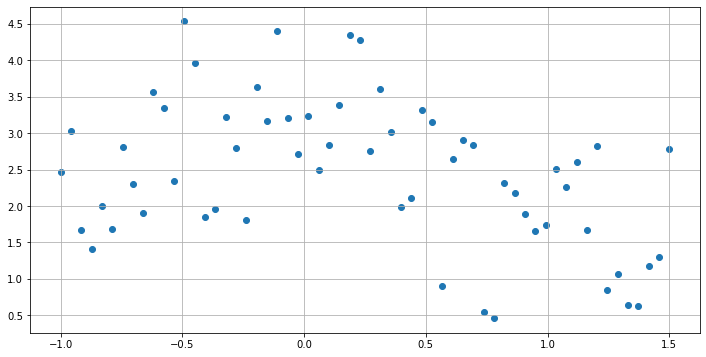

In [3]:
plt.figure(figsize=(12,6))
plt.scatter(h_train, X_train_str)
plt.grid()

### 2.2 **МНК, линейная регрессия**

In [4]:
X_train.shape

(60, 1)

In [5]:
H = np.column_stack([np.ones(N_train), h_train])

MSE = lambda X, Y: np.linalg.inv(X.T @ X) @ X.T @ Y

linear_regression = lambda theta, x: theta[0] + theta[1] * x

theta_MSE = MSE(H, X_train)
print(theta_MSE)
y_MSE = np.column_stack([linear_regression(theta_MSE, h)])
y_train_MSE = np.column_stack([linear_regression(theta_MSE, h_train)])


[[ 2.57002564]
 [-0.50696067]]


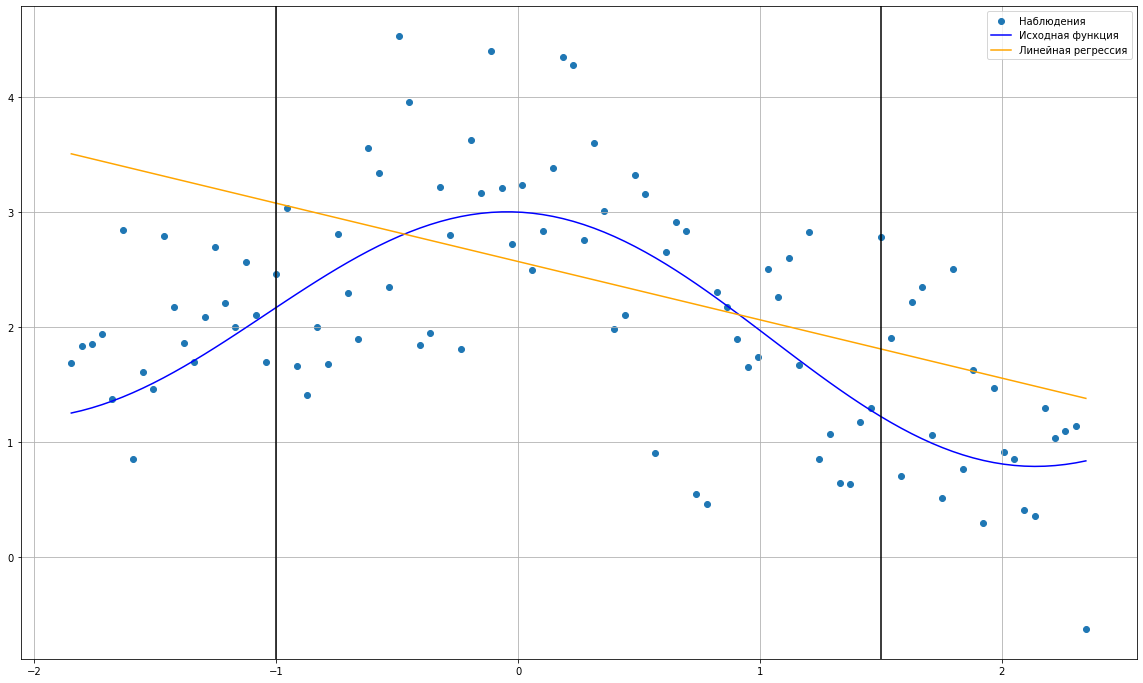

In [52]:
def graph(y, X):
    plt.figure(figsize=(20,12))
    plt.scatter(h, X, label='Наблюдения')
    plt.plot(h, f_full, color='blue', label='Исходная функция')
    plt.plot(h, y, color='orange', label='Линейная регрессия')
    ax = plt.gca()
    ax.axvline(x=-1, color='k')
    ax.axvline(x=1.5, color='k')
    plt.legend()
    plt.grid()
    
graph(y_MSE, X)

**Коэффициент детерминации**

In [7]:
def e2(X, y):
    e = X - y
    return np.sum(e ** 2)

def R(X, y):   
    ss_res = e2(X, y)
    ss_tot = np.sum((X - X.mean()) ** 2)
    R = 1 - ss_res / ss_tot
    
    return R

print(R(X_train, y_train_MSE))

0.1415903727708686


**Оценка ковариационной матрицы**

In [8]:
def K(X, y):
    ss_res = e2(X, y)
    sigma2_hat = ss_res / (N_train - 1)
    K_hat = sigma2_hat * np.linalg.inv(H.T @ H)
    return K_hat

print(K(X_train, y_train_MSE))

[[ 0.01587171 -0.00660233]
 [-0.00660233  0.02640933]]


**Информационные критерии**

In [56]:
def IC(X, y, theta=theta_MSE):
    ss_res = e2(X, y)
    sigma2_hat = ss_res / (N_train - 1)

    AIC = 2 * len(theta) / N_train + np.log(sigma2_hat)
    BIC = len(theta) * np.log(N_train) + N_train * np.log(sigma2_hat)
    
    return AIC, BIC

print(IC(X_train, y_train_MSE))

(-0.09201547880920764, -1.332239604108258)


**Критерий Фишера**

In [10]:
def Fisher(Z, H, theta, A, alpha=0.05):
    q, p = A.shape
    N = len(Z)
    F = ((A @ theta).T @ np.linalg.inv(A @ np.linalg.inv(H.T @ H) @ A.T) @ (A @ theta)) / (q / (N - p) * (Z - H @ theta).T @ (Z - H @ theta))
    p_value = f.sf(F, q, N-p)
    return F, p_value, p_value > alpha

In [11]:
Fisher(X_train, H, theta_MSE, np.array([[1, 0], [0, 1]]))

(array([[211.11248479]]), array([[2.38514299e-27]]), array([[False]]))

На уровне значимости $\alpha=0.05$ гипотеза о том, что неизвестные параметры равны нулю,

**Доверительные интервалы**

In [12]:
def interval(u, y=y_MSE):
    def d(t):
        h = np.column_stack([[1, t]])
        x = h.T @ np.linalg.inv(H.T @ H) @ h
        return sigma2 * x

    d_full = d(h)[0][0]
    lower = np.squeeze(y.reshape(1, 100)) - u * d_full
    upper = np.squeeze(y.reshape(1, 100)) + u * d_full

    plt.figure(figsize=(20,10))
    plt.scatter(h, X, label='Наблюдения')
    plt.plot(h, f_full, color='blue', label='Исходная функция')
    plt.plot(h, y, color='orange', label='Линейная регрессия')
    plt.plot(h, lower, color='black', label='Доверительный интервал')
    plt.plot(h, upper, color='black')
    plt.legend()
    plt.grid()

/home/alexandra/anaconda3/lib/python3.9/site-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = array(v, copy=False, subok=True)


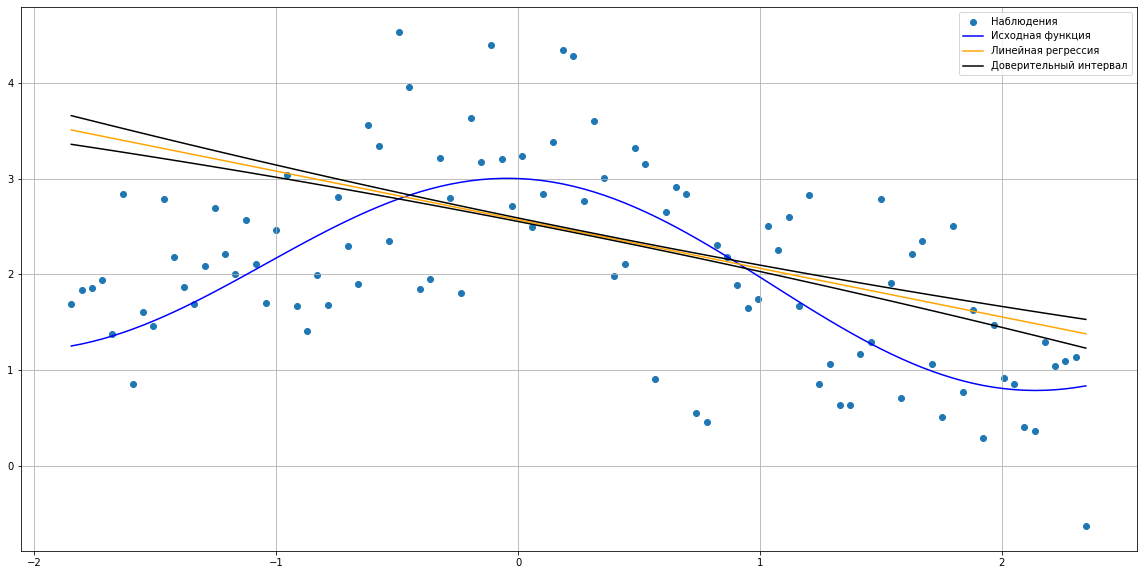

In [13]:
interval(1.96)

/home/alexandra/anaconda3/lib/python3.9/site-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = array(v, copy=False, subok=True)


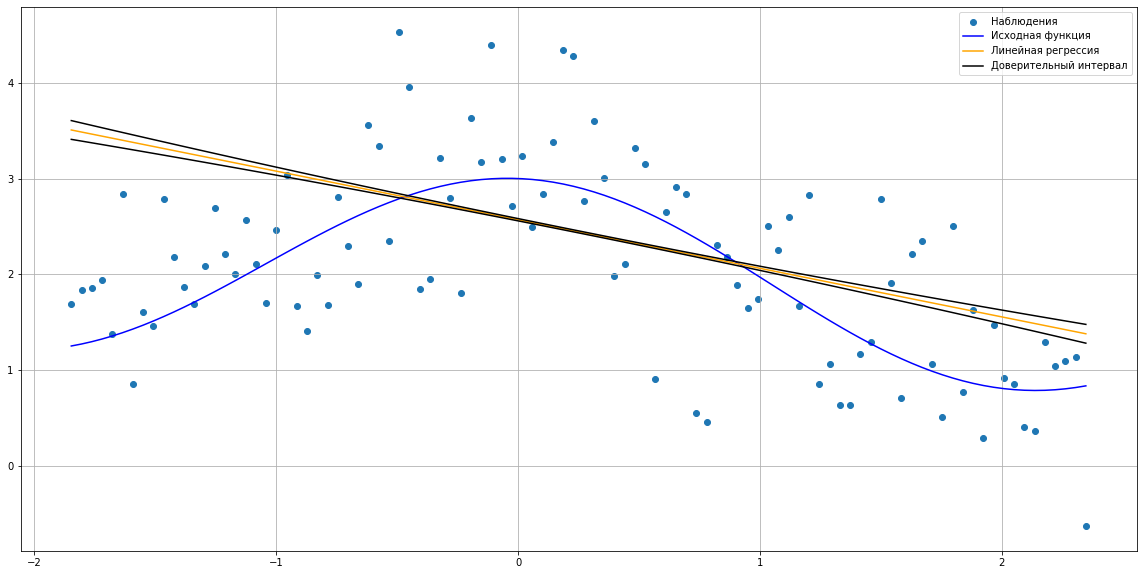

In [14]:
interval(1.282)

**МНМ**

In [15]:
def IRLS(X, Y, maxiter, d=0.0001, t=0.001):
    N = len(Y)
    delta = np.array(np.repeat(d, N)).reshape(1, N)
    w = np.ones(N)
    W = np.diag(w)
    THETA = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ Y)
    for i in range(maxiter):
        THETA_ = THETA
        w_ = abs(Y - np.dot(X, THETA)).T
        w = 1 / np.maximum(delta, w_)
        w = np.squeeze(w)
        W = np.diag(w)
        THETA = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ Y)
        #print(THETA)
        if sum(abs(THETA - THETA_)) < t:
            return THETA
    return THETA

theta_MAE = IRLS(H, X_train_str, 20)
print(theta_MAE)

[ 2.63028558 -0.42216433]


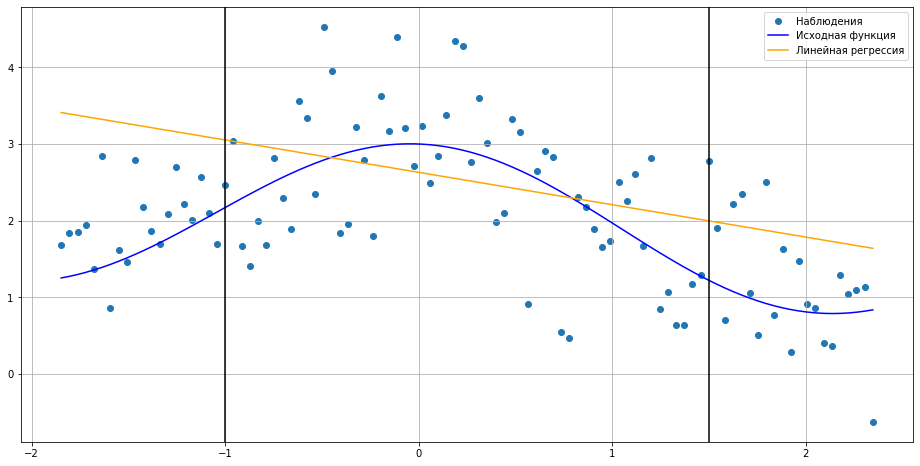

In [16]:
y_MAE = np.column_stack([linear_regression(theta_MAE, h)])
y_train_MAE = np.column_stack([linear_regression(theta_MAE, h_train)])

graph(y_MAE, X)

**Оценка качества построенных регрессий**

In [17]:
def test_MSE(y, y_hat):
    return np.sum((y - y_hat) ** 2)

def test_MAE(y, y_hat):
    return np.sum(abs(y - y_hat))

y_test_MSE = linear_regression(theta_MSE, h_test)
y_test_MAE = linear_regression(theta_MAE, h_test)


yMSE_MSE = test_MSE(X_test, y_test_MSE)
yMAE_MSE = test_MSE(X_test, y_test_MAE)
print("Сумма квадратов остатков на тестовой выборке, МНК:", yMSE_MSE, "\nСумма квадратов остатков на тестовой выборке, МНМ:", yMAE_MSE)

yMSE_MAE = test_MAE(X_test, y_test_MSE)
yMAE_MAE = test_MAE(X_test, y_test_MAE)
print("Сумма модулей остатков на тестовой выборке, МНК:", yMSE_MAE, "\nСумма модулей остатков на тестовой выборке, МНМ:", yMAE_MAE)

print("\nКоэффициент детерминации на тестовой выборке, МНК:", R(X_test, y_test_MSE))
print("Коэффициент детерминации на тестовой выборке, МНК:", R(X_test, y_test_MAE))

Сумма квадратов остатков на тестовой выборке, МНК: 55.800580941232504 
Сумма квадратов остатков на тестовой выборке, МНМ: 57.981328192207364
Сумма модулей остатков на тестовой выборке, МНК: 40.615594905449655 
Сумма модулей остатков на тестовой выборке, МНМ: 42.389878342405076

Коэффициент детерминации на тестовой выборке, МНК: -1.3656862405105588
Коэффициент детерминации на тестовой выборке, МНК: -1.4581398257356968


**Анализ остатков**

In [57]:
def polinom(theta, x):
    f = 0
    for i in range(len(theta)):
        f += theta[i] *  x ** i
    return f

theta = lambda n: [1] * n

rho = lambda theta, y, x: y - polinom(theta, x)


def Goldfild_Quandt(X, h, p=2, alpha=0.05):
    x = X[::-1]
    h = h[::-1]
    n = len(x)
    if n // 3 > p:
        d = n // 3
    else:
        d = (n - 2 * p) // 2
    
    x1 = x[:(n - d) // 2]
    h1 = h[:(n - d) // 2]

    x2 = x[n - (n - d) // 2:]
    h2 = h[n - (n - d) // 2:]
    
    th1 = least_squares(rho, theta(p), args=(x1, h1), method='lm') 
    th2 = least_squares(rho, theta(p), args=(x2, h2), method='lm')
    
    F = e2(x1, polinom(th1.x, h1)) / e2(x2, polinom(th2.x, h2))
    df = (n - d) // 2 - p
    p_value = f.sf(F, df, df)
    
    return p_value, p_value >= alpha

def errors_info(e, h):
    plt.figure(figsize=(13,10))
    plt.title("Гистограмма остатков")
    sns.histplot(e, color="dodgerblue", kde=True, stat='probability')
    plt.show()
    print("\nПроверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:")
    print(shapiro(e))
    print("\nПроверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:")
    D = durbin_watson(e)
    r_hat = 1 - D / 2
    print(D, r_hat)
    print("\nПроверка гипотезы о гомоскедастичности, Критерий Голдфилда-Куандта:")
    print(Goldfild_Quandt(e, h))

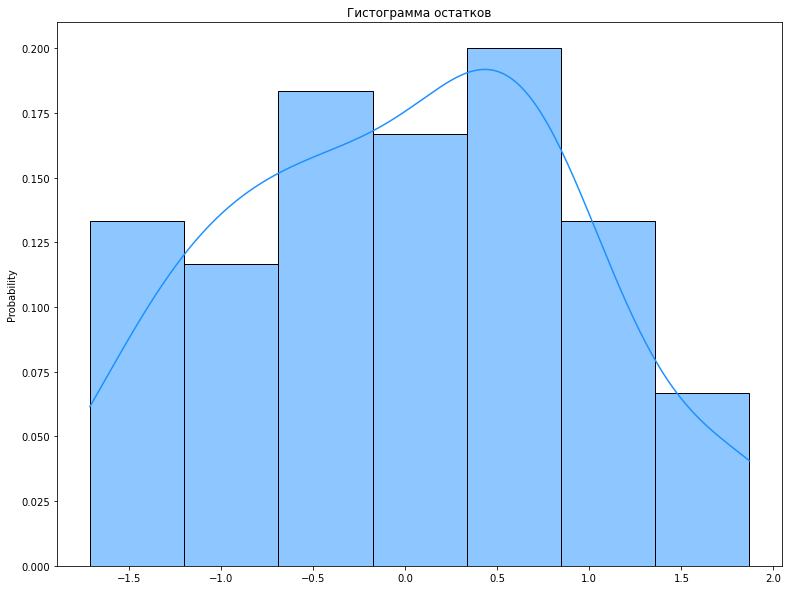


Проверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:
ShapiroResult(statistic=0.9756567478179932, pvalue=0.27302056550979614)

Проверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:
1.2291342210608476 0.3854328894695762

Проверка гипотезы о гомоскедастичности, Критерий Голдфилда-Куандта:
(0.5327622653559041, True)


In [59]:
e = X_train_str - y_train_MSE.ravel()

errors_info(e, h_train)

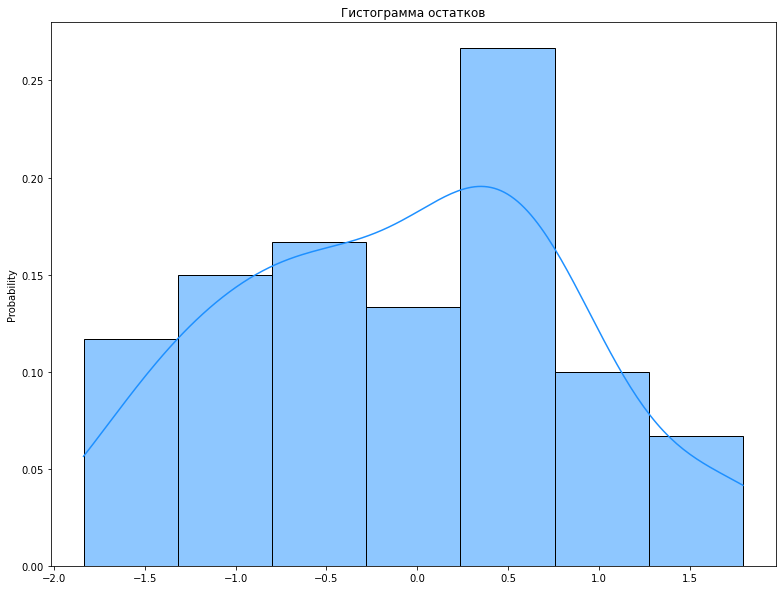


Проверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:
ShapiroResult(statistic=0.9756153225898743, pvalue=0.2718032896518707)

Проверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:
1.213723559006345 0.39313822049682745

Проверка гипотезы о наличии гетероскедастичности, Критерий Голдфилда-Куандта:
(0.5327622653559041, True)


In [20]:
e = X_train_str - y_train_MAE.ravel()
errors_info(e, h_train)

### 2.3 **Полиномиальная регрессия**

In [21]:
def LS(n, y, x):
    theta_ls = least_squares(rho, theta(n), args=(y, x), method='lm') 
    y_res = polinom(theta_ls.x, h_test)
    K_hat = K(X_test, y_res)
    sigma2_hat = e2(y_res, X_test) / (N_train - 1)
    
    trace = np.trace(K_hat)
    
    H = np.ones(len(y))
    
    for i in range(1, n):
        H = np.c_[H, x ** i]
    
    F, p, flag = Fisher(X_train, H, np.column_stack([theta_ls.x]), np.array([[0 for _ in range(n-1)] + [1]]))
    #print(F.shape , 'p-value для критерия Фишера:', p, '\nРавняется ли параметр при старшей степени нулю на уровне значимости 0.05:', flag)
    
    mse = test_MSE(y_res, X_test)
    plt.figure(figsize=(16,8))
    plt.scatter(h, X, label='Наблюдения')
    plt.plot(h, f_full, color='blue', label='Исходная функция')
    plt.plot(h, polinom(theta_ls.x, h), color='orange', label='Полиномиальная регрессия')
    ax = plt.gca()
    ax.axvline(x=-1, color='k')
    ax.axvline(x=1.5, color='k')
    plt.legend()
    plt.grid()
    return theta_ls.x, mse, float(p), bool(flag), float(F), sigma2_hat * trace
    #print('Оценка параметров:', theta_ls.x, '\nСумма квадратов остатков на тестовой выборке:', mse)
    
def train(N):
    th, mse, p, flag, F, r = LS(N, X_train_str, h_train)

    print('Оценка параметров:', th, 
          '\nс.к. погрешность на тестовой выборке:', r, 
          '\nКритерий Фишера: \n\tp-value:', p, '\n\tГипотеза о равенстве нулю параметра при старшей степени принимается:', flag, '\n\tСтатистика критерия:', F,
          '\nСумма квадратов остатков на тестовой выборке:', mse)


Оценка параметров: [ 2.57002564 -0.50696067] 
с.к. погрешность на тестовой выборке: 0.04432347888238474 
Критерий Фишера: 
	p-value: 0.003045427974339327 
	Гипотеза о равенстве нулю параметра при старшей степени принимается: False 
	Статистика критерия: 9.566809858379067 
Сумма квадратов остатков на тестовой выборке: 55.80058099954503


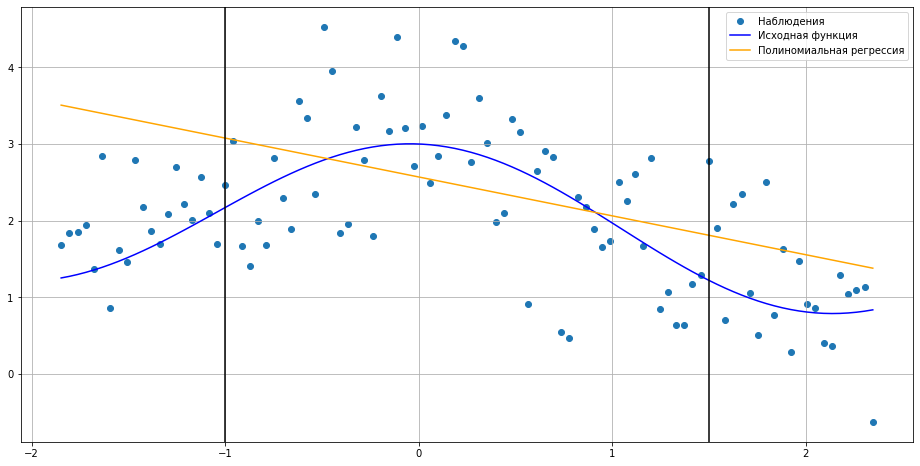

In [22]:
train(2)

Оценка параметров: [ 2.9753889  -0.08114882 -0.85162371] 
с.к. погрешность на тестовой выборке: 0.08724250583286101 
Критерий Фишера: 
	p-value: 0.0003786015828317891 
	Гипотеза о равенстве нулю параметра при старшей степени принимается: False 
	Статистика критерия: 14.281233689372895 
Сумма квадратов остатков на тестовой выборке: 78.286317776972


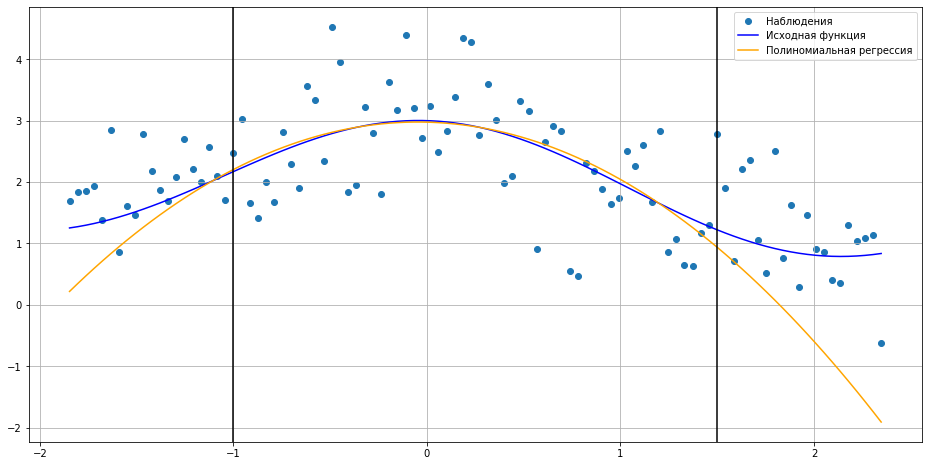

In [23]:
train(3)

Оценка параметров: [ 3.11621991 -0.56678759 -1.31773518  0.62148197] 
с.к. погрешность на тестовой выборке: 0.9092870183155073 
Критерий Фишера: 
	p-value: 0.07556552856014763 
	Гипотеза о равенстве нулю параметра при старшей степени принимается: True 
	Статистика критерия: 3.278342866172861 
Сумма квадратов остатков на тестовой выборке: 252.73901942440892


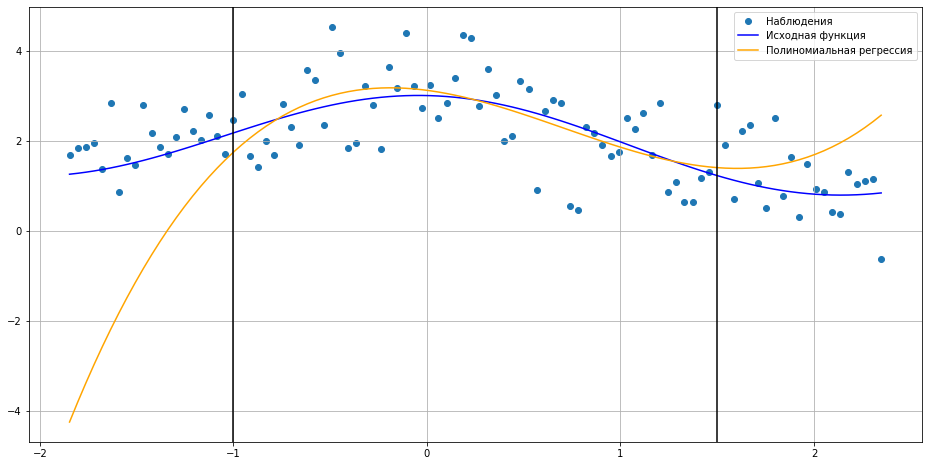

In [24]:
train(4)

Оценка параметров: [ 3.20930345 -0.15033911 -1.98516505 -0.04038642  0.66186839] 
с.к. погрешность на тестовой выборке: 5.536546981374383 
Критерий Фишера: 
	p-value: 0.22082703974664605 
	Гипотеза о равенстве нулю параметра при старшей степени принимается: True 
	Статистика критерия: 1.533638281647728 
Сумма квадратов остатков на тестовой выборке: 623.6505297091041


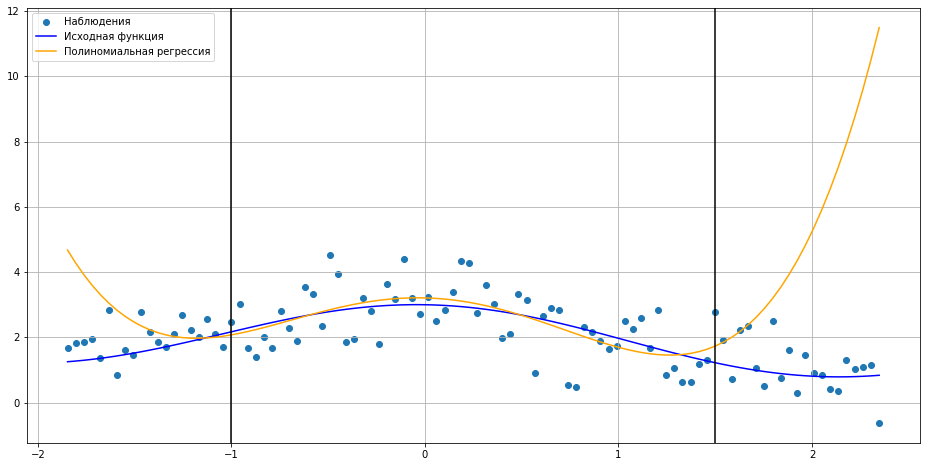

In [25]:
train(5)

След ковариационной матрицы сильно возрос, как и сумма квадратов остатков на тестовой выборке, поэтому остановимся на четвёртой степени полинома

**Анализ остатков**

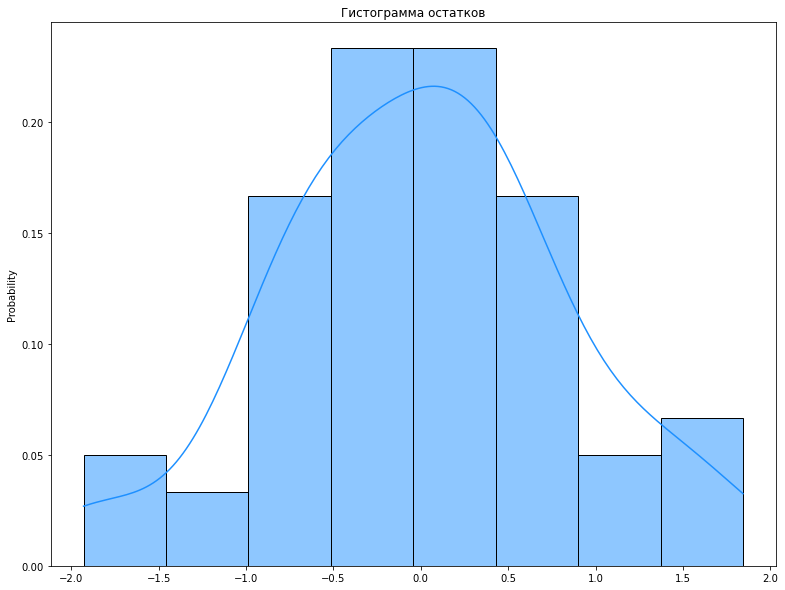


Проверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:
ShapiroResult(statistic=0.9865700006484985, pvalue=0.7512081861495972)

Проверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:
1.542707631618417 0.22864618419079152

Проверка гипотезы о гомоскедастичности, Критерий Голдфилда-Куандта:
(0.5318059164456869, True)


In [60]:
th = least_squares(rho, theta(3), args=(X_train_str, h_train), method='lm').x

e = X_train_str - polinom(th, h_train)

errors_info(e, h_train)

**Проверка на мультиколлинеарность**

In [27]:
H_pol = np.column_stack([np.ones(N_train), h_train, h_train ** 2])
W = H_pol.T @ H_pol
ev = np.linalg.eigvals(W)
print(ev)
cond_num = max(ev) / min(ev)
print(cond_num)

[100.67223688  30.16495274   8.87766987]
11.339939240380469


Матрица не мультиколлинеарна

### 2.4 **Регрессия для наблюдений с выбросами**

In [28]:
import scipy.stats as ss

def TukeyDistribution(h, sigma2, mu=0, delta=0.08):
    l = []
    for i in h:
        if np.random.uniform() > delta:
            l.append(truef(i) + np.random.normal(mu, np.sqrt(sigma2)))
        else:
            l.append(truef(i) + np.random.normal(mu, np.sqrt(100 * sigma2)))
            
    return np.array(l)

**МНК оценка и её качество**

In [29]:
T = TukeyDistribution(h, sigma2)
T_train_str = T[N_test // 2:N_test // 2 + N_train]
T_test_left = T[:N_test // 2]
T_test_right = T[N_test // 2 + N_train:]
T_train = np.column_stack([T_train_str])

tukey_theta = MSE(H, T_train)

y_train_tukey = np.column_stack([linear_regression(tukey_theta, h_train)])

print(tukey_theta)
print(R(T_train, y_train_tukey))

[[ 2.51236842]
 [-1.12912794]]
0.08631805402655068


In [30]:
Fisher(T_train, H, tukey_theta, np.array([[1, 0], [0, 1]]))

(array([[22.58626277]]), array([[5.57255066e-08]]), array([[False]]))

**Анализ остатков**

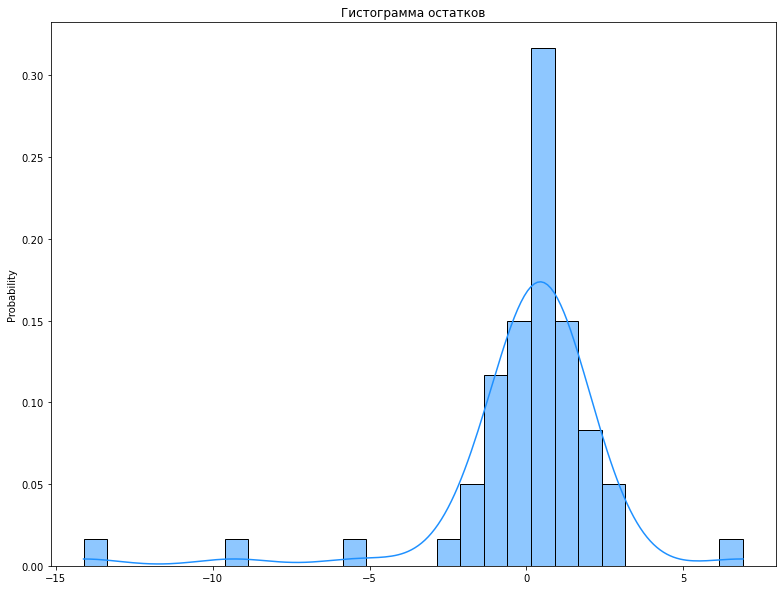


Проверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:
ShapiroResult(statistic=0.6760183572769165, pvalue=3.1451805049265147e-10)

Проверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:
2.2594297542167823 -0.12971487710839114

Проверка гипотезы о наличии гетероскедастичности, Критерий Голдфилда-Куандта:
(0.012282478018989575, False)


In [31]:
e_tukey = T_train_str - linear_regression(tukey_theta, h_train) 

errors_info(e_tukey, h_train)

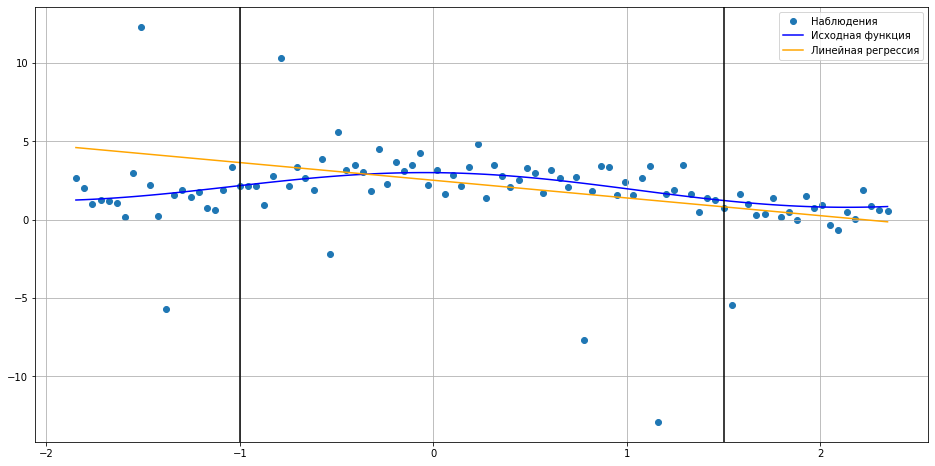

In [32]:
y_tukey = np.column_stack([linear_regression(tukey_theta, h)])
graph(y_tukey, T)

**Отбраковка выбросов**

In [33]:
def rejection(e, X, h):
    l, hn = [], []
    med = np.median(abs(e))
    sigma = 2 * med / 0.675
    for i in range(len(e)):
        if abs(e[i]) <= sigma:
            l.append(X[i])
            hn.append(h[i])
    H = np.column_stack([np.ones(len(hn)), hn])
    return np.array(l), H

T_clear, H_clear = rejection(e_tukey, T_train_str, h_train)
H_clear_str = H_clear[:,1].ravel()

tukey_theta_clear = MSE(H_clear,  np.column_stack([T_clear]))

y_train_tukey_clear = np.column_stack([linear_regression(tukey_theta_clear, h)])

print("МНК-оценка после отбраковки выбросов:", tukey_theta_clear.ravel())
print("Коэф. детерминации после отбраковки выбросов", R(T_clear, y_train_tukey_clear))

МНК-оценка после отбраковки выбросов: [ 2.67398832 -0.43906104]
Коэф. детерминации после отбраковки выбросов -137.46183520109537


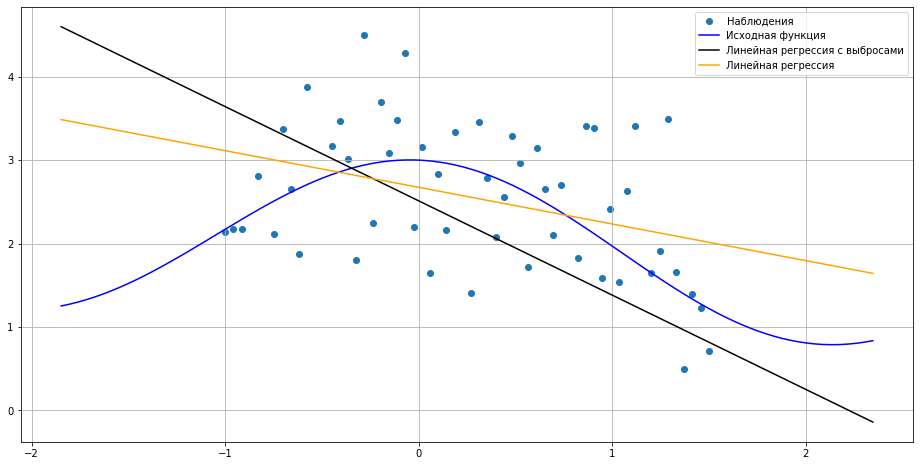

In [34]:
plt.figure(figsize=(16,8))
plt.scatter(H_clear_str, T_clear, label='Наблюдения')
plt.plot(h, f_full, color='blue', label='Исходная функция')
plt.plot(h, y_tukey, color='black', label='Линейная регрессия с выбросами')
plt.plot(h, y_train_tukey_clear, color='orange', label='Линейная регрессия')
plt.grid()
plt.legend()

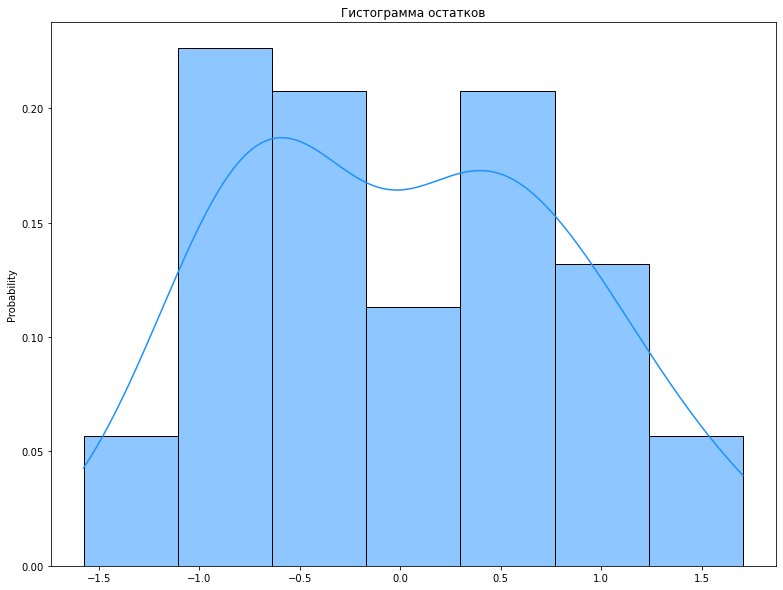


Проверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:
ShapiroResult(statistic=0.9713594317436218, pvalue=0.2309187799692154)

Проверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:
2.069349515540051 -0.03467475777002549

Проверка гипотезы о наличии гетероскедастичности, Критерий Голдфилда-Куандта:
(0.26481377175215365, True)


In [35]:
e_tukey_clear = T_clear - linear_regression(tukey_theta_clear, H_clear_str) 

errors_info(e_tukey_clear, H_clear_str)

**МНМ-оценка**

In [36]:
theta_tukey_MAE = IRLS(H, T_train_str, 20)
print(theta_tukey_MAE)

[ 2.73358321 -0.76478156]


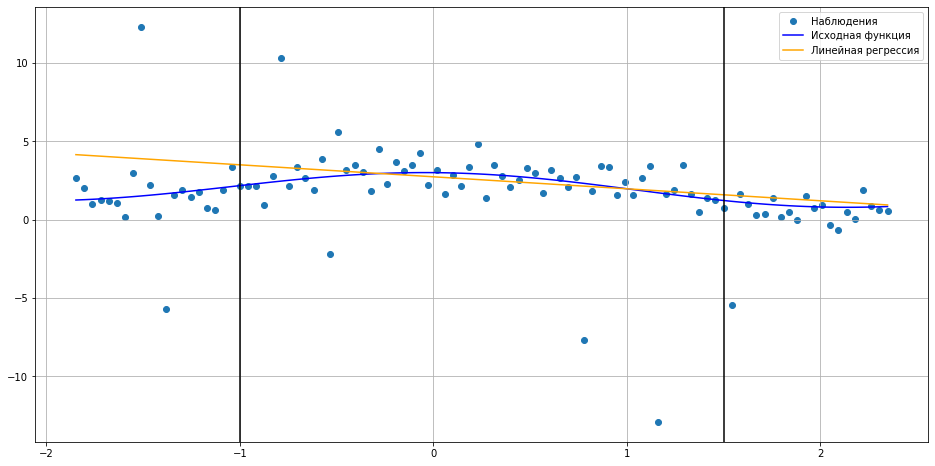

In [37]:
y_tukey_MAE = np.column_stack([linear_regression(theta_tukey_MAE, h)])
graph(y_tukey_MAE, T)

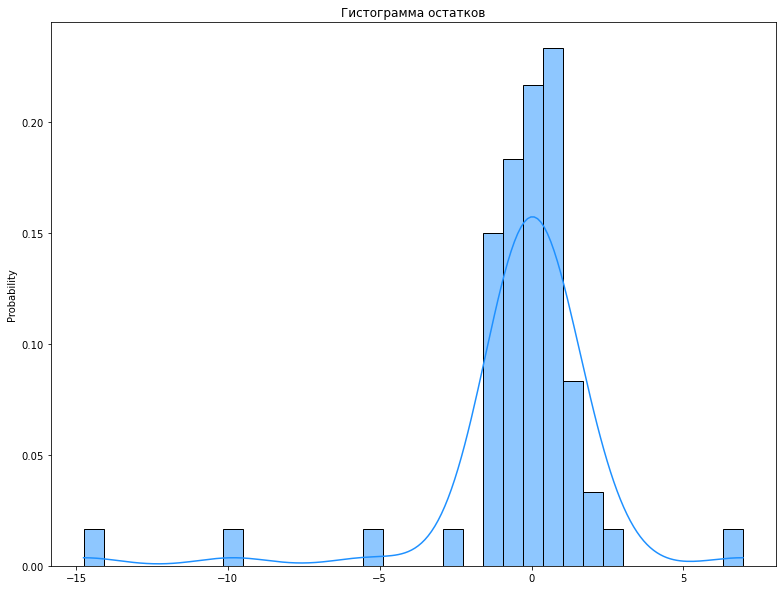


Проверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:
ShapiroResult(statistic=0.6430296301841736, pvalue=8.18732720508919e-11)

Проверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:
2.208009083485513 -0.10400454174275642

Проверка гипотезы о наличии гетероскедастичности, Критерий Голдфилда-Куандта:
(0.012282478018989575, False)


In [38]:
e = T_train_str - linear_regression(theta_tukey_MAE, h_train)
errors_info(e, h_train)

**Оценка Хьюбера**

In [39]:
def Huber(u, delta=1):
    return 0.5 * u ** 2 if abs(u) < delta else delta * (abs(u) - 0.5 * delta)   

def minHuber(theta, y, H, delta=1):
    return np.sum([Huber(yi - np.sum(theta * h), delta) for yi, h in zip(y, H)])

theta_huber = fmin(minHuber, theta_tukey_MAE, args=(T_train_str, H))
print(theta_huber)

y_tukey_huber = linear_regression(theta_huber, h)

Optimization terminated successfully.
         Current function value: 57.494270
         Iterations: 32
         Function evaluations: 64
[ 2.63301748 -0.46882017]


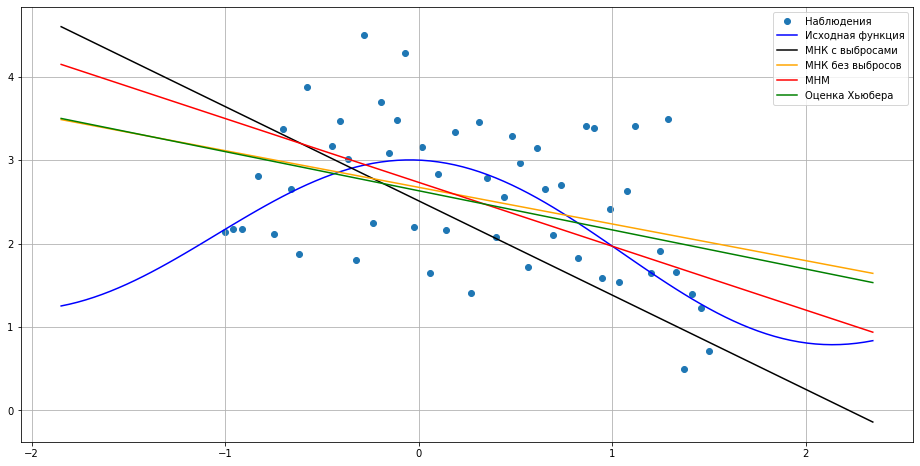

In [40]:
plt.figure(figsize=(16,8))
plt.scatter(H_clear_str, T_clear, label='Наблюдения')
plt.plot(h, f_full, color='blue', label='Исходная функция')
plt.plot(h, y_tukey, color='black', label='МНК с выбросами')
plt.plot(h, y_train_tukey_clear, color='orange', label='МНК без выбросов')
plt.plot(h, y_tukey_MAE, color='red', label='МНМ')
plt.plot(h, y_tukey_huber, color='green', label='Оценка Хьюбера')
plt.grid()
plt.legend()

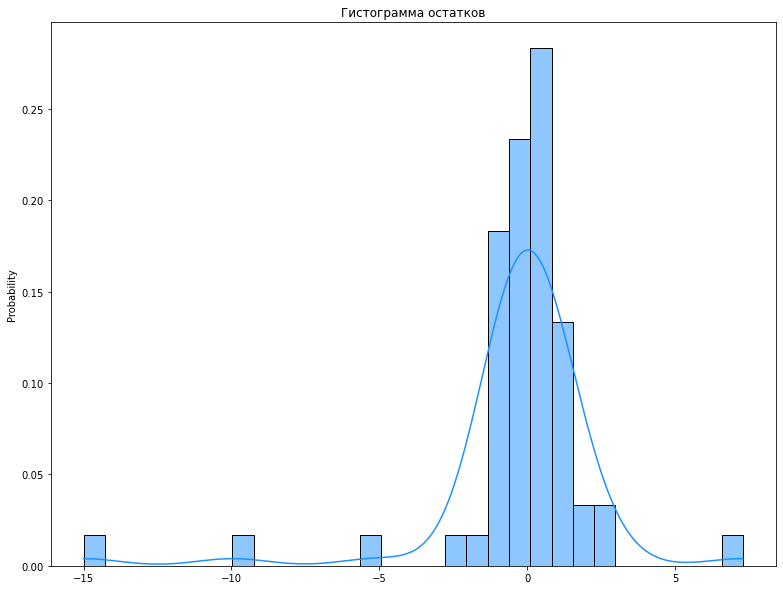


Проверка гипотезы о нормальном распределении, критерий Шапиро-Уилка:
ShapiroResult(statistic=0.6280303001403809, pvalue=4.5648439889189873e-11)

Проверка гипотезы о наличии автокорреляции, Критерий Дарбина-Уотсона:
2.165082765744797 -0.08254138287239843

Проверка гипотезы о наличии гетероскедастичности, Критерий Голдфилда-Куандта:
(0.012282478018989575, False)


In [41]:
e = T_train_str - linear_regression(theta_huber, h_train)
errors_info(e, h_train)

### 2.5 **Квантильная регрессия**

In [42]:
print(errors)

[ 0.43436946  0.56457133  0.55877464  0.61520239  0.01828279  1.45029046
 -0.57394614  0.14293819 -0.05546558  1.2314737   0.57165235  0.20607922
 -0.01630742  0.32526986  0.87567438  0.33416907  0.06998394  0.57304791
  0.05370457 -0.4117849   0.29431012  0.80481556 -0.62322424 -0.93301173
 -0.40445006 -0.77902975  0.29940017 -0.26761779 -0.71604237  0.89690567
  0.63069306 -0.40472136  1.74051667  1.12985328 -1.01592073 -0.9389211
  0.29753855 -0.14371725 -1.15575503  0.65195379  0.17871365  1.40073635
  0.20533251 -0.28334529  0.23499395 -0.49752888 -0.14096023  0.41773273
  1.40214314  1.35582675 -0.13084045  0.7386389   0.18244863 -0.80337928
 -0.64234412  0.61997773  0.5014916  -1.69303288  0.10110107  0.41741046
  0.39894898 -1.82238873 -1.84863318  0.05913558 -0.00749797 -0.22562327
 -0.40127869 -0.24466755  0.58583408  0.4085935   0.82105613 -0.04475712
  1.17609023 -0.72889813 -0.44897342 -0.81336999 -0.7593973  -0.16264588
  0.01958898  1.55983746  0.73741208 -0.41055076  1.

In [43]:
def count(err):
    new = 0
    for e in err:
        if e < 0:
            new += 1
    return new

print(count(errors))

41


In [44]:
def change(err):
    l = []
    for e in err:
        if e < 0:
            if np.random.uniform() <= 0.9:
                l.append(abs(e))
            else:
                l.append(e)
        else:
            l.append(e)
    return l

In [45]:
nerr = change(errors)
print(count(nerr))

5


In [46]:
Xqua = f_full + nerr

Xqua_train_str = Xqua[N_test // 2:N_test // 2 + N_train]
Xqua_test_left = Xqua[:N_test // 2]
Xqua_test_right = Xqua[N_test // 2 + N_train:]
Xqua_test = np.concatenate((Xqua_test_left, Xqua_test_right))
Xqua_train = np.column_stack([Xqua_train_str])

[[ 3.13609186]
 [-0.5493755 ]]


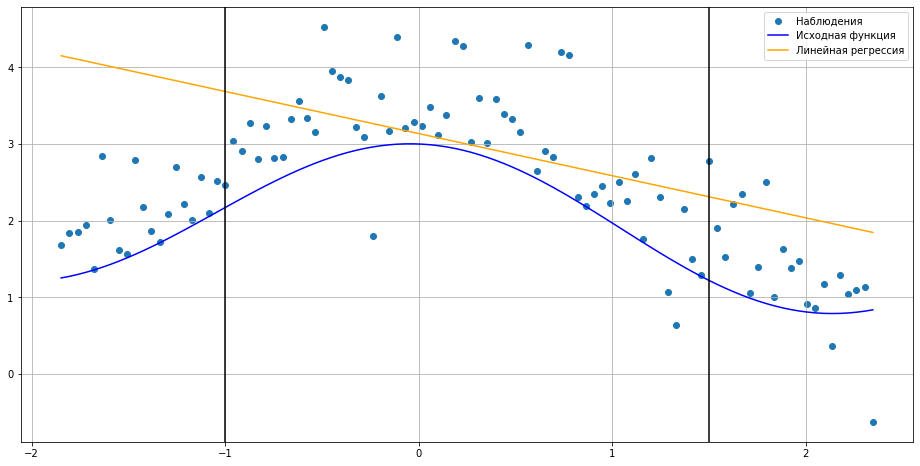

In [47]:
theta_MSE_qua = MSE(H, Xqua_train)
print(theta_MSE_qua)
yqua_MSE = np.column_stack([linear_regression(theta_MSE_qua, h)])
yqua_train_MSE = np.column_stack([linear_regression(theta_MSE_qua, h_train)])

graph(yqua_MSE, Xqua)

[ 3.10007658 -0.44506004]


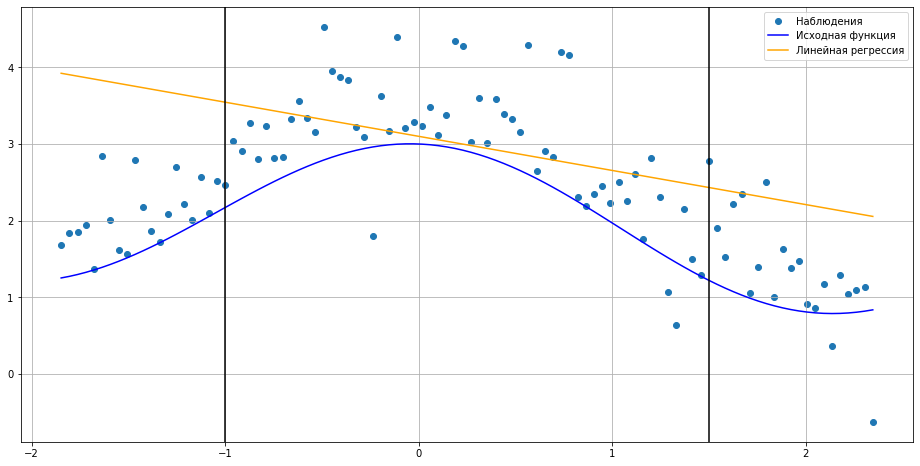

In [48]:
theta_MAE_qua = IRLS(H, Xqua_train_str, 20)
print(theta_MAE_qua)

yqua_MAE = np.column_stack([linear_regression(theta_MAE_qua, h)])
yqua_train_MAE = np.column_stack([linear_regression(theta_MAE_qua, h_train)])

graph(yqua_MAE, Xqua)

In [49]:
def I(u):
    return 1 if u < 0 else 0

def g(alpha, u):
    return u * (alpha - I(u))

def J(theta, X, H, alpha):
    s = 0
    Y = H @ theta
    for x, y in zip(X, Y):
        s += g(alpha, x-y)
    return s

In [50]:
theta_qua025 = fmin(J, theta_MAE_qua, args=(Xqua_train_str, H, 0.25))
theta_qua05 = fmin(J, theta_MAE_qua, args=(Xqua_train_str, H, 0.5))
theta_qua075 = fmin(J, theta_MAE_qua, args=(Xqua_train_str, H, 0.75))
print(theta_qua025, theta_qua05, theta_qua075)

Optimization terminated successfully.
         Current function value: 13.218070
         Iterations: 41
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: 16.076892
         Iterations: 25
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: 13.591981
         Iterations: 63
         Function evaluations: 122
[ 2.78728518 -0.56307657] [ 3.09998624 -0.44497992] [ 3.53159599 -0.49998886]


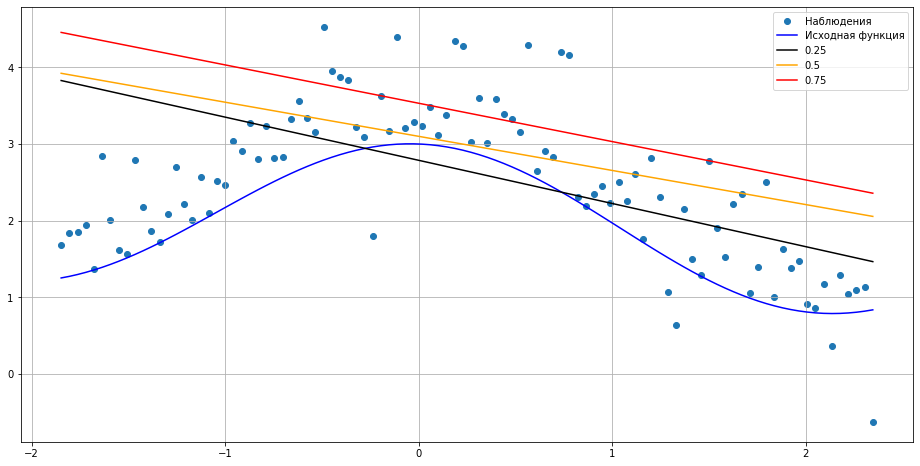

In [51]:
yqua025 = linear_regression(theta_qua025, h)
yqua05 = linear_regression(theta_qua05, h)
yqua075 = linear_regression(theta_qua075, h)

plt.figure(figsize=(16,8))
plt.scatter(h, Xqua, label='Наблюдения')
plt.plot(h, f_full, color='blue', label='Исходная функция')
plt.plot(h, yqua025, color='black', label='0.25')
plt.plot(h, yqua05, color='orange', label='0.5')
plt.plot(h, yqua075, color='red', label='0.75')
plt.grid()
plt.legend()